In [12]:
# Updated Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch import nn
from torch import optim
# Function to save and display Grad-CAM using PyTorch
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.jet

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8)).resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = Image.fromarray(np.uint8(superimposed_img))

    # Save the superimposed image
    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)


In [13]:
class RetinaModel(nn.Module):
    def __init__(self):
        super(RetinaModel, self).__init__()
        
        # Features layers (same as original)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [14]:
model = RetinaModel()

In [15]:
model.load_state_dict(torch.load('RetinaModel.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [16]:
model.eval()

RetinaModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(

In [17]:
import torch
import torch.nn.functional as F
from torch.autograd import Function

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate_heatmap(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output[0, class_idx]
        loss.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * activations, dim=1).squeeze()

        heatmap = F.relu(heatmap)
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()
        return heatmap.cpu().data.numpy()

# Example usage:
# grad_cam = GradCAM(model, model.layer4[-1])
# heatmap = grad_cam.generate_heatmap(input_tensor, class_idx)


In [18]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the image path
img_path = r"C:\Users\manch\Research\archive\OCT2017\OCT2017\test\NORMAL\NORMAL-283376-1.jpeg"

# Load the image
img = Image.open(img_path).convert('RGB')

# Define the transformations: Resize, ToTensor, Normalize
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Apply the transformations to the image
input_tensor = transform(img)

# Add a batch dimension (required by the model)
input_tensor = input_tensor.unsqueeze(0)  # Shape: [1, 3, 224, 224]

# Now input_tensor is ready to be fed into the model
print(input_tensor.shape)


torch.Size([1, 3, 224, 224])


In [19]:
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [20]:
class_idx = 3  # ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [21]:
grad_cam = GradCAM(model, model.features[40])
heatmap = grad_cam.generate_heatmap(input_tensor, class_idx)

c:\Users\manch\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


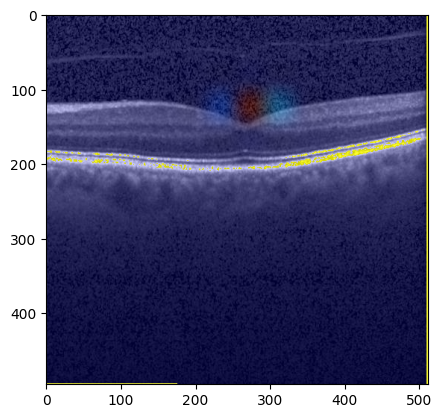

In [22]:
save_and_display_gradcam(img_path, heatmap)